In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from sklearn.metrics import mean_squared_error

# Load CSV

In [2]:
# Load CSV files into pandas DataFrames
holidays_events = pd.read_csv('data/holidays_events.csv')
oil_prices = pd.read_csv('data/oil.csv')
stores_info = pd.read_csv('data/stores.csv')
transaction_list = pd.read_csv('data/transactions.csv')
df_train = pd.read_csv('data/train.csv')

# Loading Oil prices

In [3]:
oil_prices.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [4]:
missing_values = oil_prices.isna().sum()
print(missing_values)

date           0
dcoilwtico    43
dtype: int64


Oil prices has some missing values. If we dont take care of it, while merging it with transaction table, the number of missing value will increase as there are multiple row of transaction for single date. THerefore, we take care of missing value in oil table before merging

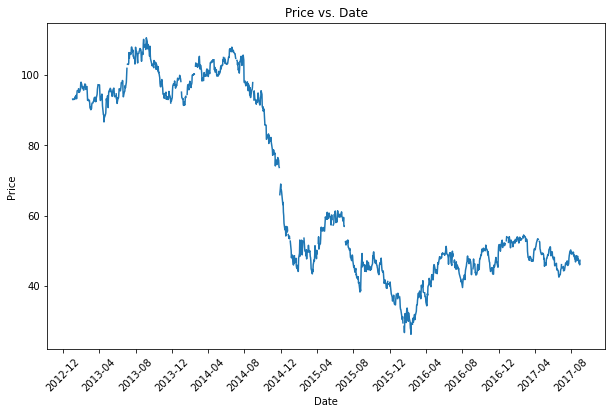

In [5]:
import matplotlib.dates as mdates

oil_prices['date'] = pd.to_datetime(oil_prices['date'])

# Sort the DataFrame by date (optional, but recommended for time series data)
oil_prices = oil_prices.sort_values(by='date')

def plot_timeseries(df):
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.plot(df['date'], df['dcoilwtico'])

    # Customize the plot
    plt.title('Price vs. Date')
    plt.xlabel('Date')
    plt.ylabel('Price')

    # Set the x-axis ticks to show dates at intervals of 4 months
    date_formatter = mdates.DateFormatter("%Y-%m")
    plt.gca().xaxis.set_major_formatter(date_formatter)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))

    # Show the plot
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()
    
    
plot_timeseries(oil_prices)

We have some null values in around 2013 august, 2014 august, and early quarter 2015. Lets fill in the null values with average of previous day and nxt day prices

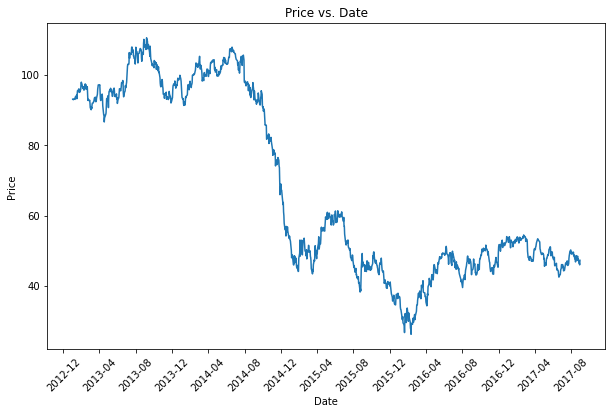

In [6]:
oil_prices['dcoilwtico'].fillna((oil_prices['dcoilwtico'].shift() + oil_prices['dcoilwtico'].shift(-1)) / 2, inplace=True)
# oil_prices['dcoilwtico'].fillna(oil_prices['dcoilwtico'].shift(-1), inplace=True)
oil_prices['dcoilwtico'].fillna(method='ffill', inplace=True)
oil_prices['dcoilwtico'].fillna(method='bfill', inplace=True)
plot_timeseries(oil_prices)

We can see that the oil prices have been filled without introducing any addition structure in the original plot

In [7]:
len(oil_prices)

1218

In [8]:
missing_values = oil_prices.isna().sum()
print(missing_values)

date          0
dcoilwtico    0
dtype: int64


# Handling other tables

In [27]:
# holidays_events.head()

In [28]:
# stores_info.head()

In [29]:
# transaction_list.head()

In [30]:
# df_train.head()

The train data only contains date, store nbr, family, sales and promotion. We have holidays information so we will merge holiday information and also store location and

# Merging df

In [13]:
# merging train and store
merged_train_store = pd.merge(df_train, stores_info, on='store_nbr', how='left')
merged_train_store = merged_train_store.rename(columns={"city": "store_city", "state": "store_state", 
                                   "type": "store_type", "cluster": "store_cluster",
                                  })
# merged_train_store.head()

In [14]:
# renaming holidays columns so that they are easier to identify upon join 
holidays_events.head()
holidays_events.columns = holidays_events.columns.map(lambda x: 'holidays_'+str(x))
holidays_events.head()

,holidays_date,holidays_type,holidays_locale,holidays_locale_name,holidays_description,holidays_transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [15]:
# further merging holidays
merged_train_store_holidays = pd.merge(merged_train_store, holidays_events, left_on='date',                                        
                                       right_on= 'holidays_date', how='left')
merged_train_store_holidays.head()

,id,date,store_nbr,family,sales,onpromotion,store_city,store_state,store_type,store_cluster,holidays_date,holidays_type,holidays_locale,holidays_locale_name,holidays_description,holidays_transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False


In [16]:
#renaming the oil price column so that it is easier to identify upon joining
oil_prices = oil_prices.rename(columns={"dcoilwtico": "oil_price"})
oil_prices.head()

,date,oil_price
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [17]:
# further merging oil prices
merged_train_store_holidays['date'] = pd.to_datetime(merged_train_store_holidays['date'])
merged_train_store_holidays_oil_price = pd.merge(merged_train_store_holidays, oil_prices, on='date',how='inner')
merged_train_store_holidays_oil_price.head()


,id,date,store_nbr,family,sales,onpromotion,store_city,store_state,store_type,store_cluster,holidays_date,holidays_type,holidays_locale,holidays_locale_name,holidays_description,holidays_transferred,oil_price
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False,93.14


In [18]:
merged_train_store_holidays_oil_price.tail()

,id,date,store_nbr,family,sales,onpromotion,store_city,store_state,store_type,store_cluster,holidays_date,holidays_type,holidays_locale,holidays_locale_name,holidays_description,holidays_transferred,oil_price
2175817,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57
2175818,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57
2175819,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57
2175820,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57
2175821,3000887,2017-08-15,9,SEAFOOD,16.000,0,Quito,Pichincha,B,6,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57


# Analyzing the dataframe

In [19]:
column_names = merged_train_store_holidays_oil_price.columns
print(column_names)
print(len(column_names))

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'store_city', 'store_state', 'store_type', 'store_cluster',
       'holidays_date', 'holidays_type', 'holidays_locale',
       'holidays_locale_name', 'holidays_description', 'holidays_transferred',
       'oil_price'],
      dtype='object')
17


In [20]:
summary_stats = merged_train_store_holidays_oil_price.describe()
print(summary_stats)

                 id     store_nbr         sales   onpromotion  store_cluster  \
count  2.175822e+06  2.175822e+06  2.175822e+06  2.175822e+06   2.175822e+06   
mean   1.500332e+06  2.750000e+01  3.223445e+02  2.827230e+00   8.481481e+00   
std    8.657937e+05  1.558579e+01  9.758211e+02  1.321435e+01   4.649735e+00   
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   1.000000e+00   
25%    7.524492e+05  1.400000e+01  0.000000e+00  0.000000e+00   4.000000e+00   
50%    1.499552e+06  2.750000e+01  1.000000e+01  0.000000e+00   8.500000e+00   
75%    2.246656e+06  4.100000e+01  1.800000e+02  0.000000e+00   1.300000e+01   
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02   1.700000e+01   

          oil_price  
count  2.175822e+06  
mean   6.794372e+01  
std    2.567221e+01  
min    2.619000e+01  
25%    4.646000e+01  
50%    5.341000e+01  
75%    9.580000e+01  
max    1.106200e+02  


In [21]:
missing_values = merged_train_store_holidays_oil_price.isna().sum()
print(missing_values)

id                            0
date                          0
store_nbr                     0
family                        0
sales                         0
onpromotion                   0
store_city                    0
store_state                   0
store_type                    0
store_cluster                 0
holidays_date           1822986
holidays_type           1822986
holidays_locale         1822986
holidays_locale_name    1822986
holidays_description    1822986
holidays_transferred    1822986
oil_price                     0
dtype: int64


Holiday data and oil price have the null values. We can replace holidays with no_holiday feature as the new one because empty data on holidays columns means no holiday. Also the oil prices can be filled with the previou day oil price.

In [22]:
num_rows, num_columns = merged_train_store_holidays_oil_price.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 2175822
Number of columns: 17


In [23]:
# filling holidays type as not_holiday, holiday_locale, holiday_locale_name, holidays_description and 
# holiday_transferred as not applicable

constant_value = 'Not a holiday'
merged_train_store_holidays_oil_price['holidays_type'] = merged_train_store_holidays_oil_price['holidays_type'].fillna(constant_value)

constant_value = 'Not applicable'
merged_train_store_holidays_oil_price['holidays_locale'] = merged_train_store_holidays_oil_price['holidays_locale'].fillna(constant_value)

merged_train_store_holidays_oil_price['holidays_locale_name'] = merged_train_store_holidays_oil_price['holidays_locale_name'].fillna(constant_value)

merged_train_store_holidays_oil_price['holidays_description'] = merged_train_store_holidays_oil_price['holidays_description'].fillna(constant_value)
merged_train_store_holidays_oil_price['holidays_transferred'] = merged_train_store_holidays_oil_price['holidays_transferred'].fillna(constant_value)

#dropping holiday date column
merged_train_store_holidays_oil_price = merged_train_store_holidays_oil_price.drop(columns=['holidays_date'])

In [24]:
# checking null values again
missing_values = merged_train_store_holidays_oil_price.isna().sum()
print(missing_values)

id                      0
date                    0
store_nbr               0
family                  0
sales                   0
onpromotion             0
store_city              0
store_state             0
store_type              0
store_cluster           0
holidays_type           0
holidays_locale         0
holidays_locale_name    0
holidays_description    0
holidays_transferred    0
oil_price               0
dtype: int64


filling in previous day oil price for the oil data

In [25]:
missing_values = merged_train_store_holidays_oil_price.isna().sum()
print(missing_values)

id                      0
date                    0
store_nbr               0
family                  0
sales                   0
onpromotion             0
store_city              0
store_state             0
store_type              0
store_cluster           0
holidays_type           0
holidays_locale         0
holidays_locale_name    0
holidays_description    0
holidays_transferred    0
oil_price               0
dtype: int64


In [31]:
merged_train_store_holidays_oil_price.head()

,id,date,store_nbr,family,sales,onpromotion,store_city,store_state,store_type,store_cluster,holidays_type,holidays_locale,holidays_locale_name,holidays_description,holidays_transferred,oil_price
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,93.14


In [26]:
# saving the merged data into csv file
merged_train_store_holidays_oil_price.to_csv('data/merged_data.csv', index=False)